In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.3.0


Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


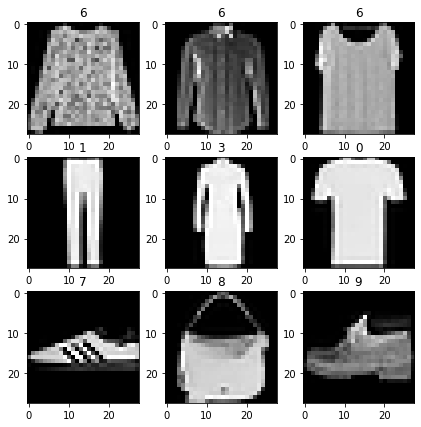

In [3]:
from tensorflow.keras.datasets import fashion_mnist, mnist

(trainX, trainY), (testX, testY) = fashion_mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testY.shape))

plt.figure(figsize=(7, 7))
for j in range(9):
    i = np.random.randint(0, 10000)
    plt.subplot(330 + 1 + j)
    plt.imshow(trainX[i], cmap='gray')
    plt.title(trainY[i])
plt.show()

In [4]:
trainX = [image/255 for image in trainX]
testX = [image/255 for image in testX]

trainX = np.reshape(trainX, (60000, 28, 28, 1))
testX = np.reshape(testX, (10000, 28, 28, 1))

print (trainX.shape, testX.shape, trainY.shape, testY.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000,) (10000,)


# Generator Model

In [5]:
random_input = tensorflow.keras.layers.Input(shape = 500)

x = tensorflow.keras.layers.Dense(256 * 5 * 5)(random_input)
x = tensorflow.keras.layers.Activation('swish')(x)

x = tensorflow.keras.layers.Reshape((5, 5, 256))(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(5,5))(x)
x = tensorflow.keras.layers.Activation('swish')(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(7,7))(x)
x = tensorflow.keras.layers.Activation('swish')(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(7,7))(x)
x = tensorflow.keras.layers.Activation('swish')(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=1, kernel_size=(8,8))(x)
generated_image = tensorflow.keras.layers.Activation('sigmoid')(x)

generator_network = tensorflow.keras.models.Model(inputs=random_input, outputs=generated_image)
generator_network.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
dense (Dense)                (None, 6400)              3206400   
_________________________________________________________________
activation (Activation)      (None, 6400)              0         
_________________________________________________________________
reshape (Reshape)            (None, 5, 5, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 9, 9, 128)         819328    
_________________________________________________________________
activation_1 (Activation)    (None, 9, 9, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 15, 15, 128)      

# Discriminator

In [6]:
image_input = tensorflow.keras.layers.Input(shape=(28, 28, 1))

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(3,3))(image_input)
x = tensorflow.keras.layers.Activation('swish')(x)
x = tensorflow.keras.layers.Dropout(0.4)(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=2)(x)
x = tensorflow.keras.layers.Activation('swish')(x)
x = tensorflow.keras.layers.Dropout(0.4)(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(5,5))(x)
x = tensorflow.keras.layers.Activation('swish')(x)
x = tensorflow.keras.layers.Dropout(0.4)(x)

x = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(7,7))(x)
x = tensorflow.keras.layers.Activation('swish')(x)
x = tensorflow.keras.layers.Dropout(0.4)(x)

x = tensorflow.keras.layers.Flatten()(x)

x = tensorflow.keras.layers.Dense(32)(x)
x = tensorflow.keras.layers.Dropout(0.4)(x)
x = tensorflow.keras.layers.Activation('swish')(x)

x = tensorflow.keras.layers.Dense(1)(x)
real_vs_fake_output = tensorflow.keras.layers.Activation('sigmoid')(x)

discriminator_network = tensorflow.keras.models.Model(inputs=image_input, outputs=real_vs_fake_output)
discriminator_network.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 128)       1280      
_________________________________________________________________
activation_5 (Activation)    (None, 26, 26, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 128)       409728    
_________________________________________________________________
activation_6 (Activation)    (None, 11, 11, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 11, 128)      

In [7]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
discriminator_network.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

# GAN

In [8]:
discriminator_network.trainable=False
gan_input = generator_network(random_input)
gan_output = discriminator_network(gan_input)

gan_model = tensorflow.keras.models.Model(random_input, gan_output)
gan_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
functional_1 (Functional)    (None, 28, 28, 1)         5639809   
_________________________________________________________________
functional_3 (Functional)    (None, 1)                 1224321   
Total params: 6,864,130
Trainable params: 5,639,809
Non-trainable params: 1,224,321
_________________________________________________________________


# Compiling Models

In [9]:
gan_model.compile(loss='binary_crossentropy', optimizer=adam_optimizer)

# Define Data Generators

In [10]:
indices = [i for i in range(0, len(trainX))]

def get_random_noise(batch_size, noise_size):
    random_values = np.random.randn(batch_size*noise_size)
    random_noise_batch = np.reshape(random_values, (batch_size, noise_size))
    return random_noise_batch

def get_fake_samples(generator_network, batch_size, noise_size):
    random_noise_batch = get_random_noise(batch_size, noise_size) 
    fake_samples = generator_network.predict_on_batch(random_noise_batch)
    return fake_samples

def get_real_samples(batch_size):
    random_indices = np.random.choice(indices, size=batch_size)
    real_images = trainX[np.array(random_indices),:]
    return real_images

def show_generator_results(generator_network):
    fake_samples = get_fake_samples(generator_network, 10, noise_size)
    # for i in range(0, len(fake_samples)):
    #     plt.imshow(fake_samples[i,:,:,-1], cmap='gray')
    #     plt.show()

    plt.figure(figsize=(7, 7))
    for j in range(9):
        i = j
        plt.subplot(330 + 1 + j)
        plt.imshow(fake_samples[i,:,:,-1], cmap='gray')
    plt.show()
    return

# Training GAN

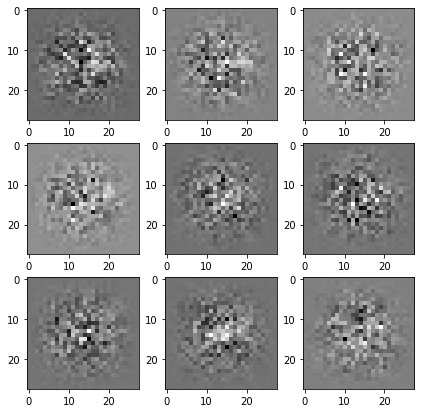

Epoch:0, Step:0, D-Loss:0.692, D-Acc:56.000, G-Loss:0.692
Epoch:0, Step:50, D-Loss:0.515, D-Acc:87.000, G-Loss:1.733
Epoch:0, Step:100, D-Loss:0.179, D-Acc:98.000, G-Loss:1.626
Epoch:0, Step:150, D-Loss:0.267, D-Acc:92.000, G-Loss:2.307
Epoch:0, Step:200, D-Loss:0.338, D-Acc:89.000, G-Loss:1.889
Epoch:0, Step:250, D-Loss:0.287, D-Acc:90.000, G-Loss:2.099
Epoch:0, Step:300, D-Loss:0.521, D-Acc:77.000, G-Loss:1.143
Epoch:0, Step:350, D-Loss:0.640, D-Acc:66.000, G-Loss:1.061
Epoch:0, Step:400, D-Loss:0.522, D-Acc:66.000, G-Loss:1.073
Epoch:0, Step:450, D-Loss:0.592, D-Acc:62.000, G-Loss:1.010
Epoch:1, Step:0, D-Loss:0.513, D-Acc:77.000, G-Loss:0.957
Epoch:1, Step:50, D-Loss:0.510, D-Acc:75.000, G-Loss:1.041
Epoch:1, Step:100, D-Loss:0.626, D-Acc:68.000, G-Loss:1.005
Epoch:1, Step:150, D-Loss:0.561, D-Acc:71.000, G-Loss:0.953
Epoch:1, Step:200, D-Loss:0.632, D-Acc:64.000, G-Loss:1.197
Epoch:1, Step:250, D-Loss:0.494, D-Acc:82.000, G-Loss:0.845
Epoch:1, Step:300, D-Loss:0.566, D-Acc:68.000,

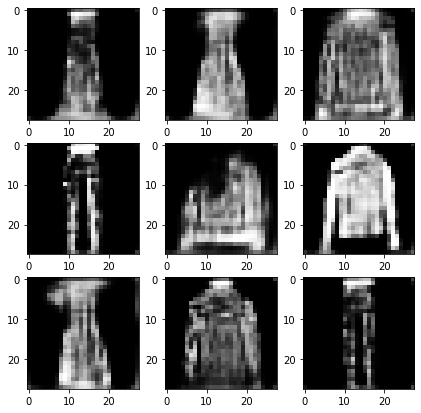

Epoch:10, Step:0, D-Loss:0.660, D-Acc:60.000, G-Loss:0.873
Epoch:10, Step:50, D-Loss:0.667, D-Acc:64.000, G-Loss:0.881
Epoch:10, Step:100, D-Loss:0.644, D-Acc:54.000, G-Loss:0.806
Epoch:10, Step:150, D-Loss:0.624, D-Acc:63.000, G-Loss:0.864
Epoch:10, Step:200, D-Loss:0.678, D-Acc:58.000, G-Loss:0.844
Epoch:10, Step:250, D-Loss:0.642, D-Acc:59.000, G-Loss:0.816
Epoch:10, Step:300, D-Loss:0.550, D-Acc:78.000, G-Loss:0.829
Epoch:10, Step:350, D-Loss:0.703, D-Acc:57.000, G-Loss:0.853
Epoch:10, Step:400, D-Loss:0.606, D-Acc:63.000, G-Loss:0.818
Epoch:10, Step:450, D-Loss:0.609, D-Acc:60.000, G-Loss:0.903
Epoch:11, Step:0, D-Loss:0.643, D-Acc:59.000, G-Loss:0.856
Epoch:11, Step:50, D-Loss:0.645, D-Acc:60.000, G-Loss:0.876
Epoch:11, Step:100, D-Loss:0.654, D-Acc:59.000, G-Loss:0.878
Epoch:11, Step:150, D-Loss:0.666, D-Acc:61.000, G-Loss:0.819
Epoch:11, Step:200, D-Loss:0.666, D-Acc:57.000, G-Loss:0.827
Epoch:11, Step:250, D-Loss:0.644, D-Acc:52.000, G-Loss:0.803
Epoch:11, Step:300, D-Loss:0.7

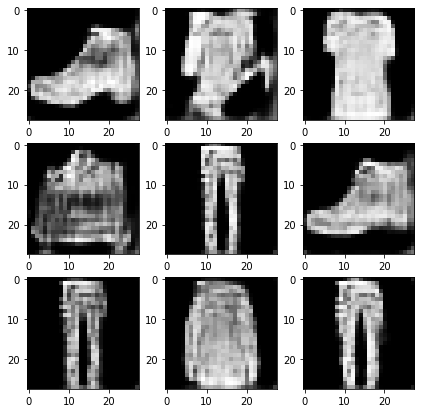

Epoch:20, Step:0, D-Loss:0.658, D-Acc:62.000, G-Loss:0.820
Epoch:20, Step:50, D-Loss:0.642, D-Acc:62.000, G-Loss:0.794
Epoch:20, Step:100, D-Loss:0.641, D-Acc:58.000, G-Loss:0.789
Epoch:20, Step:150, D-Loss:0.638, D-Acc:56.000, G-Loss:0.761
Epoch:20, Step:200, D-Loss:0.685, D-Acc:57.000, G-Loss:0.811
Epoch:20, Step:250, D-Loss:0.640, D-Acc:56.000, G-Loss:0.798
Epoch:20, Step:300, D-Loss:0.649, D-Acc:58.000, G-Loss:0.788
Epoch:20, Step:350, D-Loss:0.642, D-Acc:58.000, G-Loss:0.832
Epoch:20, Step:400, D-Loss:0.625, D-Acc:59.000, G-Loss:0.742
Epoch:20, Step:450, D-Loss:0.645, D-Acc:62.000, G-Loss:0.790
Epoch:21, Step:0, D-Loss:0.643, D-Acc:55.000, G-Loss:0.838
Epoch:21, Step:50, D-Loss:0.618, D-Acc:66.000, G-Loss:0.801
Epoch:21, Step:100, D-Loss:0.632, D-Acc:61.000, G-Loss:0.806
Epoch:21, Step:150, D-Loss:0.652, D-Acc:61.000, G-Loss:0.749
Epoch:21, Step:200, D-Loss:0.665, D-Acc:53.000, G-Loss:0.781
Epoch:21, Step:250, D-Loss:0.675, D-Acc:56.000, G-Loss:0.793
Epoch:21, Step:300, D-Loss:0.6

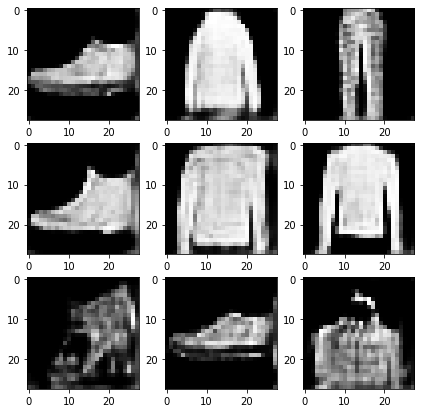

Epoch:30, Step:0, D-Loss:0.602, D-Acc:64.000, G-Loss:0.807
Epoch:30, Step:50, D-Loss:0.667, D-Acc:59.000, G-Loss:0.829
Epoch:30, Step:100, D-Loss:0.647, D-Acc:62.000, G-Loss:0.828
Epoch:30, Step:150, D-Loss:0.702, D-Acc:59.000, G-Loss:0.813
Epoch:30, Step:200, D-Loss:0.667, D-Acc:54.000, G-Loss:0.872
Epoch:30, Step:250, D-Loss:0.667, D-Acc:60.000, G-Loss:0.811
Epoch:30, Step:300, D-Loss:0.684, D-Acc:59.000, G-Loss:0.760
Epoch:30, Step:350, D-Loss:0.644, D-Acc:58.000, G-Loss:0.780
Epoch:30, Step:400, D-Loss:0.653, D-Acc:61.000, G-Loss:0.809
Epoch:30, Step:450, D-Loss:0.647, D-Acc:56.000, G-Loss:0.812
Epoch:31, Step:0, D-Loss:0.660, D-Acc:53.000, G-Loss:0.780
Epoch:31, Step:50, D-Loss:0.666, D-Acc:64.000, G-Loss:0.802
Epoch:31, Step:100, D-Loss:0.603, D-Acc:63.000, G-Loss:0.793
Epoch:31, Step:150, D-Loss:0.640, D-Acc:58.000, G-Loss:0.797
Epoch:31, Step:200, D-Loss:0.671, D-Acc:54.000, G-Loss:0.781
Epoch:31, Step:250, D-Loss:0.635, D-Acc:57.000, G-Loss:0.781
Epoch:31, Step:300, D-Loss:0.6

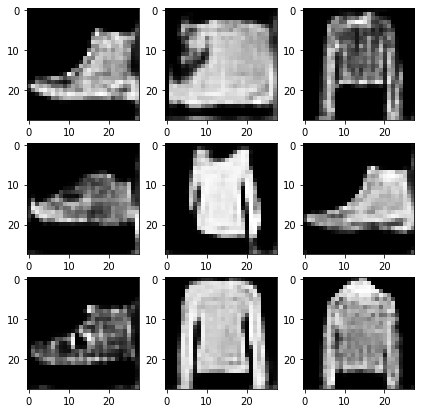

Epoch:40, Step:0, D-Loss:0.636, D-Acc:62.000, G-Loss:0.832
Epoch:40, Step:50, D-Loss:0.662, D-Acc:57.000, G-Loss:0.812
Epoch:40, Step:100, D-Loss:0.654, D-Acc:58.000, G-Loss:0.850
Epoch:40, Step:150, D-Loss:0.680, D-Acc:51.000, G-Loss:0.805
Epoch:40, Step:200, D-Loss:0.654, D-Acc:61.000, G-Loss:0.860
Epoch:40, Step:250, D-Loss:0.623, D-Acc:62.000, G-Loss:0.860
Epoch:40, Step:300, D-Loss:0.649, D-Acc:60.000, G-Loss:0.802
Epoch:40, Step:350, D-Loss:0.704, D-Acc:50.000, G-Loss:0.886
Epoch:40, Step:400, D-Loss:0.636, D-Acc:59.000, G-Loss:0.799
Epoch:40, Step:450, D-Loss:0.615, D-Acc:65.000, G-Loss:0.767
Epoch:41, Step:0, D-Loss:0.663, D-Acc:58.000, G-Loss:0.813
Epoch:41, Step:50, D-Loss:0.637, D-Acc:64.000, G-Loss:0.819
Epoch:41, Step:100, D-Loss:0.626, D-Acc:63.000, G-Loss:0.807
Epoch:41, Step:150, D-Loss:0.631, D-Acc:61.000, G-Loss:0.774
Epoch:41, Step:200, D-Loss:0.637, D-Acc:60.000, G-Loss:0.805
Epoch:41, Step:250, D-Loss:0.668, D-Acc:54.000, G-Loss:0.766
Epoch:41, Step:300, D-Loss:0.6

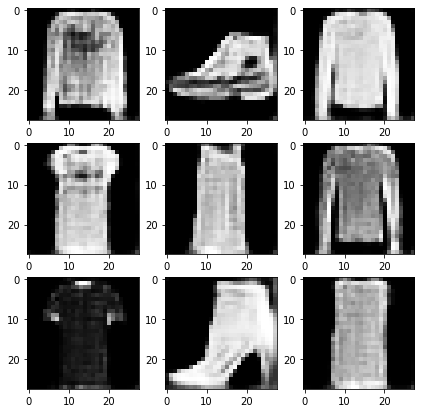

Epoch:50, Step:0, D-Loss:0.613, D-Acc:67.000, G-Loss:0.847
Epoch:50, Step:50, D-Loss:0.617, D-Acc:65.000, G-Loss:0.866
Epoch:50, Step:100, D-Loss:0.589, D-Acc:72.000, G-Loss:0.864
Epoch:50, Step:150, D-Loss:0.604, D-Acc:67.000, G-Loss:0.824
Epoch:50, Step:200, D-Loss:0.636, D-Acc:59.000, G-Loss:0.929
Epoch:50, Step:250, D-Loss:0.626, D-Acc:65.000, G-Loss:0.817
Epoch:50, Step:300, D-Loss:0.624, D-Acc:63.000, G-Loss:0.780
Epoch:50, Step:350, D-Loss:0.627, D-Acc:60.000, G-Loss:0.871
Epoch:50, Step:400, D-Loss:0.642, D-Acc:59.000, G-Loss:0.861
Epoch:50, Step:450, D-Loss:0.642, D-Acc:62.000, G-Loss:0.854
Epoch:51, Step:0, D-Loss:0.625, D-Acc:65.000, G-Loss:0.822
Epoch:51, Step:50, D-Loss:0.639, D-Acc:62.000, G-Loss:0.857
Epoch:51, Step:100, D-Loss:0.608, D-Acc:64.000, G-Loss:0.871
Epoch:51, Step:150, D-Loss:0.643, D-Acc:60.000, G-Loss:0.874
Epoch:51, Step:200, D-Loss:0.624, D-Acc:68.000, G-Loss:0.804
Epoch:51, Step:250, D-Loss:0.615, D-Acc:73.000, G-Loss:0.772
Epoch:51, Step:300, D-Loss:0.5

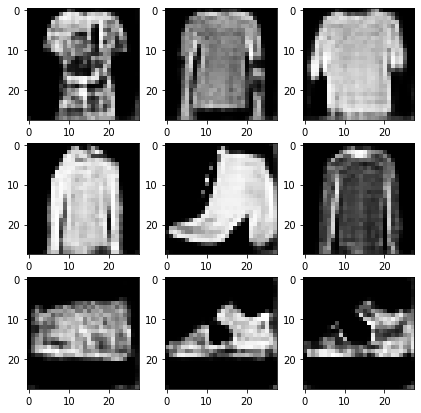

Epoch:60, Step:0, D-Loss:0.590, D-Acc:67.000, G-Loss:0.932
Epoch:60, Step:50, D-Loss:0.606, D-Acc:70.000, G-Loss:0.796
Epoch:60, Step:100, D-Loss:0.617, D-Acc:70.000, G-Loss:0.852
Epoch:60, Step:150, D-Loss:0.636, D-Acc:56.000, G-Loss:0.884
Epoch:60, Step:200, D-Loss:0.596, D-Acc:73.000, G-Loss:0.860
Epoch:60, Step:250, D-Loss:0.617, D-Acc:63.000, G-Loss:0.806
Epoch:60, Step:300, D-Loss:0.562, D-Acc:71.000, G-Loss:0.878
Epoch:60, Step:350, D-Loss:0.617, D-Acc:68.000, G-Loss:0.868
Epoch:60, Step:400, D-Loss:0.674, D-Acc:52.000, G-Loss:0.902
Epoch:60, Step:450, D-Loss:0.616, D-Acc:69.000, G-Loss:0.880
Epoch:61, Step:0, D-Loss:0.616, D-Acc:65.000, G-Loss:0.869
Epoch:61, Step:50, D-Loss:0.626, D-Acc:65.000, G-Loss:0.892
Epoch:61, Step:100, D-Loss:0.643, D-Acc:65.000, G-Loss:0.861
Epoch:61, Step:150, D-Loss:0.615, D-Acc:65.000, G-Loss:0.852
Epoch:61, Step:200, D-Loss:0.609, D-Acc:70.000, G-Loss:0.825
Epoch:61, Step:250, D-Loss:0.607, D-Acc:73.000, G-Loss:0.882
Epoch:61, Step:300, D-Loss:0.5

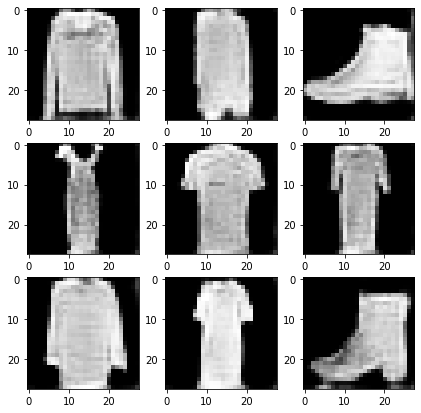

Epoch:70, Step:0, D-Loss:0.619, D-Acc:62.000, G-Loss:0.880
Epoch:70, Step:50, D-Loss:0.625, D-Acc:62.000, G-Loss:0.914
Epoch:70, Step:100, D-Loss:0.666, D-Acc:58.000, G-Loss:0.886
Epoch:70, Step:150, D-Loss:0.630, D-Acc:60.000, G-Loss:0.855
Epoch:70, Step:200, D-Loss:0.608, D-Acc:64.000, G-Loss:0.907
Epoch:70, Step:250, D-Loss:0.673, D-Acc:55.000, G-Loss:0.823
Epoch:70, Step:300, D-Loss:0.563, D-Acc:75.000, G-Loss:0.923
Epoch:70, Step:350, D-Loss:0.608, D-Acc:70.000, G-Loss:0.825
Epoch:70, Step:400, D-Loss:0.599, D-Acc:69.000, G-Loss:0.835
Epoch:70, Step:450, D-Loss:0.635, D-Acc:64.000, G-Loss:0.879
Epoch:71, Step:0, D-Loss:0.604, D-Acc:66.000, G-Loss:0.863
Epoch:71, Step:50, D-Loss:0.587, D-Acc:67.000, G-Loss:0.859
Epoch:71, Step:100, D-Loss:0.594, D-Acc:62.000, G-Loss:0.809
Epoch:71, Step:150, D-Loss:0.667, D-Acc:55.000, G-Loss:0.816
Epoch:71, Step:200, D-Loss:0.616, D-Acc:58.000, G-Loss:0.903
Epoch:71, Step:250, D-Loss:0.631, D-Acc:59.000, G-Loss:0.892
Epoch:71, Step:300, D-Loss:0.6

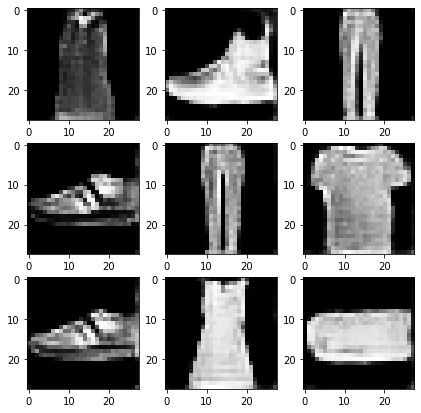

Epoch:80, Step:0, D-Loss:0.638, D-Acc:64.000, G-Loss:0.928
Epoch:80, Step:50, D-Loss:0.593, D-Acc:63.000, G-Loss:0.933
Epoch:80, Step:100, D-Loss:0.555, D-Acc:70.000, G-Loss:0.905
Epoch:80, Step:150, D-Loss:0.699, D-Acc:56.000, G-Loss:0.949
Epoch:80, Step:200, D-Loss:0.574, D-Acc:65.000, G-Loss:0.903
Epoch:80, Step:250, D-Loss:0.650, D-Acc:59.000, G-Loss:0.950
Epoch:80, Step:300, D-Loss:0.558, D-Acc:71.000, G-Loss:0.848
Epoch:80, Step:350, D-Loss:0.639, D-Acc:57.000, G-Loss:0.834
Epoch:80, Step:400, D-Loss:0.624, D-Acc:63.000, G-Loss:0.889
Epoch:80, Step:450, D-Loss:0.594, D-Acc:68.000, G-Loss:0.867
Epoch:81, Step:0, D-Loss:0.615, D-Acc:66.000, G-Loss:0.879
Epoch:81, Step:50, D-Loss:0.555, D-Acc:68.000, G-Loss:0.847
Epoch:81, Step:100, D-Loss:0.733, D-Acc:58.000, G-Loss:0.881
Epoch:81, Step:150, D-Loss:0.596, D-Acc:66.000, G-Loss:0.900
Epoch:81, Step:200, D-Loss:0.588, D-Acc:67.000, G-Loss:0.853
Epoch:81, Step:250, D-Loss:0.624, D-Acc:64.000, G-Loss:0.888
Epoch:81, Step:300, D-Loss:0.6

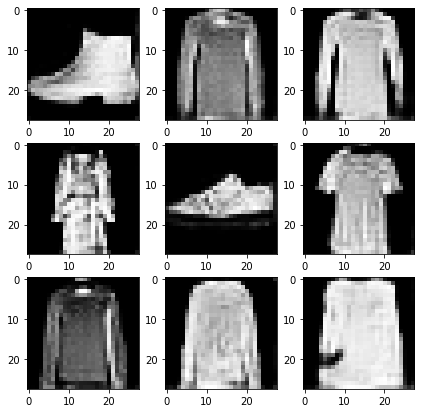

Epoch:90, Step:0, D-Loss:0.603, D-Acc:63.000, G-Loss:0.982
Epoch:90, Step:50, D-Loss:0.654, D-Acc:58.000, G-Loss:0.923
Epoch:90, Step:100, D-Loss:0.630, D-Acc:62.000, G-Loss:1.040
Epoch:90, Step:150, D-Loss:0.564, D-Acc:69.000, G-Loss:0.866
Epoch:90, Step:200, D-Loss:0.598, D-Acc:65.000, G-Loss:0.865
Epoch:90, Step:250, D-Loss:0.641, D-Acc:56.000, G-Loss:0.922
Epoch:90, Step:300, D-Loss:0.545, D-Acc:75.000, G-Loss:0.958
Epoch:90, Step:350, D-Loss:0.588, D-Acc:72.000, G-Loss:0.897
Epoch:90, Step:400, D-Loss:0.593, D-Acc:68.000, G-Loss:0.882
Epoch:90, Step:450, D-Loss:0.580, D-Acc:71.000, G-Loss:0.895
Epoch:91, Step:0, D-Loss:0.564, D-Acc:67.000, G-Loss:0.911
Epoch:91, Step:50, D-Loss:0.637, D-Acc:67.000, G-Loss:0.908
Epoch:91, Step:100, D-Loss:0.658, D-Acc:63.000, G-Loss:0.879
Epoch:91, Step:150, D-Loss:0.619, D-Acc:60.000, G-Loss:1.009
Epoch:91, Step:200, D-Loss:0.608, D-Acc:66.000, G-Loss:0.930
Epoch:91, Step:250, D-Loss:0.614, D-Acc:67.000, G-Loss:0.889
Epoch:91, Step:300, D-Loss:0.6

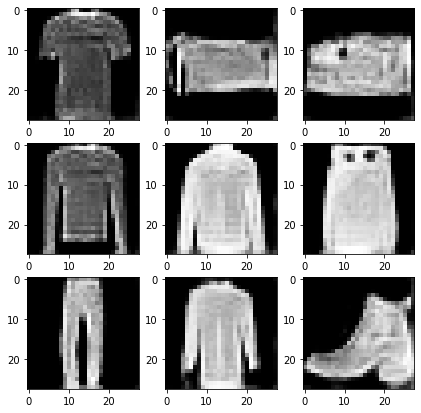

Epoch:100, Step:0, D-Loss:0.602, D-Acc:62.000, G-Loss:0.953
Epoch:100, Step:50, D-Loss:0.607, D-Acc:66.000, G-Loss:1.056
Epoch:100, Step:100, D-Loss:0.591, D-Acc:62.000, G-Loss:0.964
Epoch:100, Step:150, D-Loss:0.522, D-Acc:75.000, G-Loss:0.945
Epoch:100, Step:200, D-Loss:0.568, D-Acc:72.000, G-Loss:0.891
Epoch:100, Step:250, D-Loss:0.551, D-Acc:77.000, G-Loss:0.901
Epoch:100, Step:300, D-Loss:0.602, D-Acc:62.000, G-Loss:0.939
Epoch:100, Step:350, D-Loss:0.535, D-Acc:70.000, G-Loss:0.847
Epoch:100, Step:400, D-Loss:0.617, D-Acc:63.000, G-Loss:0.938
Epoch:100, Step:450, D-Loss:0.577, D-Acc:70.000, G-Loss:0.949
Epoch:101, Step:0, D-Loss:0.569, D-Acc:69.000, G-Loss:1.035
Epoch:101, Step:50, D-Loss:0.659, D-Acc:60.000, G-Loss:1.053
Epoch:101, Step:100, D-Loss:0.658, D-Acc:62.000, G-Loss:0.991
Epoch:101, Step:150, D-Loss:0.526, D-Acc:75.000, G-Loss:0.894
Epoch:101, Step:200, D-Loss:0.611, D-Acc:62.000, G-Loss:0.951
Epoch:101, Step:250, D-Loss:0.618, D-Acc:63.000, G-Loss:0.947
Epoch:101, Ste

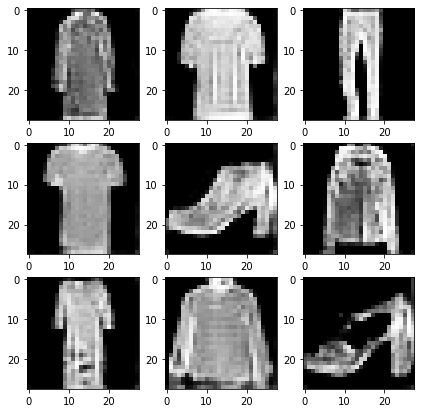

Epoch:110, Step:0, D-Loss:0.571, D-Acc:71.000, G-Loss:0.936
Epoch:110, Step:50, D-Loss:0.596, D-Acc:67.000, G-Loss:0.945
Epoch:110, Step:100, D-Loss:0.592, D-Acc:66.000, G-Loss:1.001
Epoch:110, Step:150, D-Loss:0.652, D-Acc:66.000, G-Loss:0.959
Epoch:110, Step:200, D-Loss:0.553, D-Acc:71.000, G-Loss:0.979
Epoch:110, Step:250, D-Loss:0.610, D-Acc:64.000, G-Loss:0.972
Epoch:110, Step:300, D-Loss:0.545, D-Acc:70.000, G-Loss:0.900
Epoch:110, Step:350, D-Loss:0.634, D-Acc:57.000, G-Loss:0.895
Epoch:110, Step:400, D-Loss:0.613, D-Acc:66.000, G-Loss:0.958
Epoch:110, Step:450, D-Loss:0.590, D-Acc:64.000, G-Loss:0.945
Epoch:111, Step:0, D-Loss:0.620, D-Acc:65.000, G-Loss:1.017
Epoch:111, Step:50, D-Loss:0.581, D-Acc:68.000, G-Loss:0.904
Epoch:111, Step:100, D-Loss:0.620, D-Acc:62.000, G-Loss:1.037
Epoch:111, Step:150, D-Loss:0.535, D-Acc:73.000, G-Loss:0.918
Epoch:111, Step:200, D-Loss:0.587, D-Acc:71.000, G-Loss:0.957
Epoch:111, Step:250, D-Loss:0.722, D-Acc:54.000, G-Loss:0.911
Epoch:111, Ste

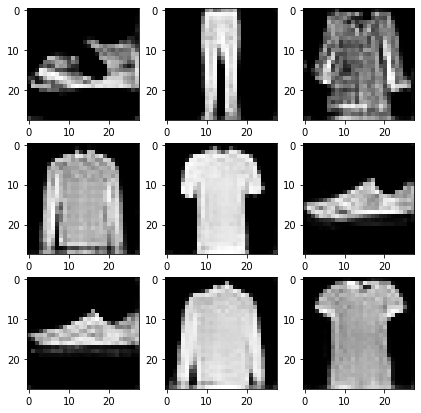

Epoch:120, Step:0, D-Loss:0.589, D-Acc:68.000, G-Loss:0.951
Epoch:120, Step:50, D-Loss:0.499, D-Acc:76.000, G-Loss:0.907
Epoch:120, Step:100, D-Loss:0.671, D-Acc:62.000, G-Loss:0.975
Epoch:120, Step:150, D-Loss:0.613, D-Acc:62.000, G-Loss:0.923
Epoch:120, Step:200, D-Loss:0.605, D-Acc:62.000, G-Loss:0.957
Epoch:120, Step:250, D-Loss:0.535, D-Acc:75.000, G-Loss:1.003
Epoch:120, Step:300, D-Loss:0.572, D-Acc:67.000, G-Loss:1.028
Epoch:120, Step:350, D-Loss:0.639, D-Acc:65.000, G-Loss:1.057
Epoch:120, Step:400, D-Loss:0.625, D-Acc:65.000, G-Loss:1.067
Epoch:120, Step:450, D-Loss:0.592, D-Acc:70.000, G-Loss:0.970
Epoch:121, Step:0, D-Loss:0.474, D-Acc:76.000, G-Loss:1.070
Epoch:121, Step:50, D-Loss:0.602, D-Acc:69.000, G-Loss:0.989
Epoch:121, Step:100, D-Loss:0.562, D-Acc:67.000, G-Loss:1.034
Epoch:121, Step:150, D-Loss:0.572, D-Acc:67.000, G-Loss:0.879
Epoch:121, Step:200, D-Loss:0.556, D-Acc:71.000, G-Loss:0.988
Epoch:121, Step:250, D-Loss:0.541, D-Acc:72.000, G-Loss:0.931
Epoch:121, Ste

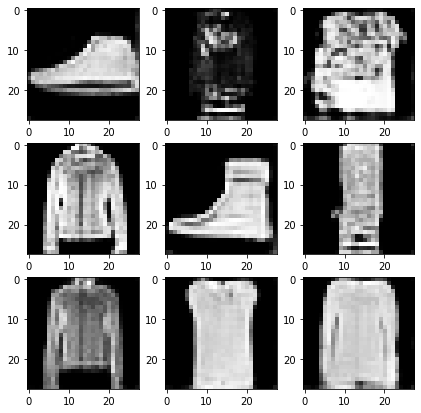

Epoch:130, Step:0, D-Loss:0.551, D-Acc:72.000, G-Loss:1.045
Epoch:130, Step:50, D-Loss:0.518, D-Acc:76.000, G-Loss:1.060
Epoch:130, Step:100, D-Loss:0.602, D-Acc:67.000, G-Loss:1.072
Epoch:130, Step:150, D-Loss:0.573, D-Acc:67.000, G-Loss:1.002
Epoch:130, Step:200, D-Loss:0.578, D-Acc:67.000, G-Loss:1.067
Epoch:130, Step:250, D-Loss:0.521, D-Acc:76.000, G-Loss:1.026
Epoch:130, Step:300, D-Loss:0.582, D-Acc:73.000, G-Loss:0.969
Epoch:130, Step:350, D-Loss:0.620, D-Acc:59.000, G-Loss:1.035
Epoch:130, Step:400, D-Loss:0.575, D-Acc:69.000, G-Loss:0.943
Epoch:130, Step:450, D-Loss:0.511, D-Acc:74.000, G-Loss:1.159
Epoch:131, Step:0, D-Loss:0.604, D-Acc:71.000, G-Loss:0.977
Epoch:131, Step:50, D-Loss:0.622, D-Acc:63.000, G-Loss:0.966
Epoch:131, Step:100, D-Loss:0.548, D-Acc:69.000, G-Loss:0.923
Epoch:131, Step:150, D-Loss:0.570, D-Acc:67.000, G-Loss:0.942
Epoch:131, Step:200, D-Loss:0.651, D-Acc:65.000, G-Loss:0.932
Epoch:131, Step:250, D-Loss:0.573, D-Acc:66.000, G-Loss:1.088
Epoch:131, Ste

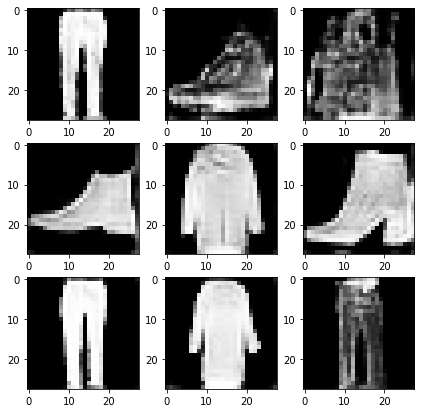

Epoch:140, Step:0, D-Loss:0.525, D-Acc:69.000, G-Loss:0.958
Epoch:140, Step:50, D-Loss:0.589, D-Acc:64.000, G-Loss:0.987
Epoch:140, Step:100, D-Loss:0.554, D-Acc:77.000, G-Loss:0.923
Epoch:140, Step:150, D-Loss:0.614, D-Acc:64.000, G-Loss:1.027
Epoch:140, Step:200, D-Loss:0.652, D-Acc:62.000, G-Loss:0.955
Epoch:140, Step:250, D-Loss:0.588, D-Acc:72.000, G-Loss:0.961
Epoch:140, Step:300, D-Loss:0.574, D-Acc:71.000, G-Loss:0.917
Epoch:140, Step:350, D-Loss:0.566, D-Acc:67.000, G-Loss:0.937
Epoch:140, Step:400, D-Loss:0.655, D-Acc:68.000, G-Loss:1.032
Epoch:140, Step:450, D-Loss:0.517, D-Acc:74.000, G-Loss:1.000
Epoch:141, Step:0, D-Loss:0.674, D-Acc:57.000, G-Loss:0.986
Epoch:141, Step:50, D-Loss:0.571, D-Acc:72.000, G-Loss:0.909
Epoch:141, Step:100, D-Loss:0.630, D-Acc:67.000, G-Loss:0.941
Epoch:141, Step:150, D-Loss:0.554, D-Acc:73.000, G-Loss:0.916
Epoch:141, Step:200, D-Loss:0.570, D-Acc:70.000, G-Loss:0.849
Epoch:141, Step:250, D-Loss:0.565, D-Acc:69.000, G-Loss:0.984
Epoch:141, Ste

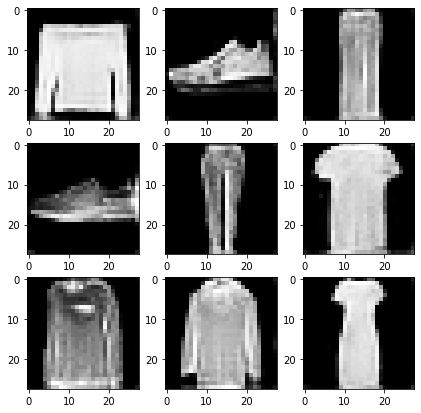

Epoch:150, Step:0, D-Loss:0.647, D-Acc:71.000, G-Loss:0.962
Epoch:150, Step:50, D-Loss:0.577, D-Acc:65.000, G-Loss:0.970
Epoch:150, Step:100, D-Loss:0.568, D-Acc:69.000, G-Loss:1.031
Epoch:150, Step:150, D-Loss:0.599, D-Acc:65.000, G-Loss:1.157
Epoch:150, Step:200, D-Loss:0.535, D-Acc:68.000, G-Loss:1.040
Epoch:150, Step:250, D-Loss:0.645, D-Acc:65.000, G-Loss:1.039
Epoch:150, Step:300, D-Loss:0.631, D-Acc:63.000, G-Loss:1.027
Epoch:150, Step:350, D-Loss:0.518, D-Acc:69.000, G-Loss:1.097
Epoch:150, Step:400, D-Loss:0.548, D-Acc:70.000, G-Loss:0.994
Epoch:150, Step:450, D-Loss:0.512, D-Acc:76.000, G-Loss:1.042
Epoch:151, Step:0, D-Loss:0.575, D-Acc:66.000, G-Loss:1.016
Epoch:151, Step:50, D-Loss:0.529, D-Acc:73.000, G-Loss:1.001
Epoch:151, Step:100, D-Loss:0.623, D-Acc:67.000, G-Loss:1.124
Epoch:151, Step:150, D-Loss:0.521, D-Acc:77.000, G-Loss:1.121
Epoch:151, Step:200, D-Loss:0.555, D-Acc:65.000, G-Loss:1.091
Epoch:151, Step:250, D-Loss:0.613, D-Acc:64.000, G-Loss:1.008
Epoch:151, Ste

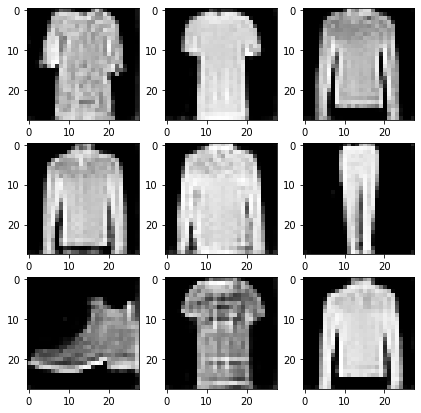

Epoch:160, Step:0, D-Loss:0.592, D-Acc:63.000, G-Loss:1.083
Epoch:160, Step:50, D-Loss:0.537, D-Acc:71.000, G-Loss:1.000
Epoch:160, Step:100, D-Loss:0.550, D-Acc:71.000, G-Loss:1.082
Epoch:160, Step:150, D-Loss:0.619, D-Acc:64.000, G-Loss:1.029
Epoch:160, Step:200, D-Loss:0.614, D-Acc:65.000, G-Loss:1.073
Epoch:160, Step:250, D-Loss:0.555, D-Acc:68.000, G-Loss:0.991
Epoch:160, Step:300, D-Loss:0.542, D-Acc:68.000, G-Loss:0.978
Epoch:160, Step:350, D-Loss:0.535, D-Acc:75.000, G-Loss:1.110
Epoch:160, Step:400, D-Loss:0.596, D-Acc:64.000, G-Loss:1.000
Epoch:160, Step:450, D-Loss:0.634, D-Acc:62.000, G-Loss:0.976
Epoch:161, Step:0, D-Loss:0.662, D-Acc:60.000, G-Loss:0.990
Epoch:161, Step:50, D-Loss:0.565, D-Acc:70.000, G-Loss:1.009
Epoch:161, Step:100, D-Loss:0.544, D-Acc:71.000, G-Loss:0.999
Epoch:161, Step:150, D-Loss:0.585, D-Acc:69.000, G-Loss:1.064
Epoch:161, Step:200, D-Loss:0.563, D-Acc:69.000, G-Loss:1.009
Epoch:161, Step:250, D-Loss:0.545, D-Acc:72.000, G-Loss:1.008
Epoch:161, Ste

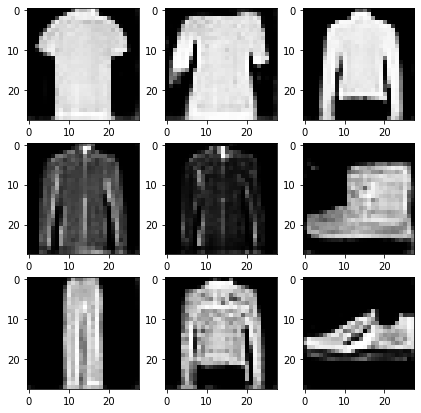

Epoch:170, Step:0, D-Loss:0.522, D-Acc:78.000, G-Loss:1.038
Epoch:170, Step:50, D-Loss:0.593, D-Acc:66.000, G-Loss:1.024
Epoch:170, Step:100, D-Loss:0.615, D-Acc:73.000, G-Loss:1.003
Epoch:170, Step:150, D-Loss:0.579, D-Acc:65.000, G-Loss:1.080
Epoch:170, Step:200, D-Loss:0.594, D-Acc:69.000, G-Loss:1.049
Epoch:170, Step:250, D-Loss:0.598, D-Acc:61.000, G-Loss:1.108
Epoch:170, Step:300, D-Loss:0.624, D-Acc:65.000, G-Loss:1.085
Epoch:170, Step:350, D-Loss:0.598, D-Acc:69.000, G-Loss:1.019
Epoch:170, Step:400, D-Loss:0.531, D-Acc:72.000, G-Loss:1.063
Epoch:170, Step:450, D-Loss:0.521, D-Acc:74.000, G-Loss:1.092
Epoch:171, Step:0, D-Loss:0.651, D-Acc:64.000, G-Loss:1.022
Epoch:171, Step:50, D-Loss:0.501, D-Acc:79.000, G-Loss:0.992
Epoch:171, Step:100, D-Loss:0.622, D-Acc:63.000, G-Loss:0.990
Epoch:171, Step:150, D-Loss:0.603, D-Acc:68.000, G-Loss:1.156
Epoch:171, Step:200, D-Loss:0.555, D-Acc:67.000, G-Loss:0.926
Epoch:171, Step:250, D-Loss:0.569, D-Acc:77.000, G-Loss:1.024
Epoch:171, Ste

KeyboardInterrupt: ignored

In [11]:
epochs = 500
batch_size = 100
steps = 500
noise_size = 500

for i in range(0, epochs):
    if (i%10 == 0):
        op = show_generator_results(generator_network)
        #print (op)
    for j in range(steps):
        fake_samples = get_fake_samples(generator_network, batch_size//2, noise_size)
        real_samples = get_real_samples(batch_size=batch_size//2)

        fake_y = np.zeros((batch_size//2, 1))
        real_y = np.ones((batch_size//2, 1))
        
        input_batch = np.vstack((fake_samples, real_samples))
        output_labels = np.vstack((fake_y, real_y))
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d = discriminator_network.train_on_batch(input_batch, output_labels)
        
        gan_input = get_random_noise(batch_size, noise_size)
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        gan_output = np.ones((batch_size))
        
        # Updating Generator weights
        discriminator_network.trainable=False
        loss_g = gan_model.train_on_batch(gan_input, gan_output)
        
        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g))
            

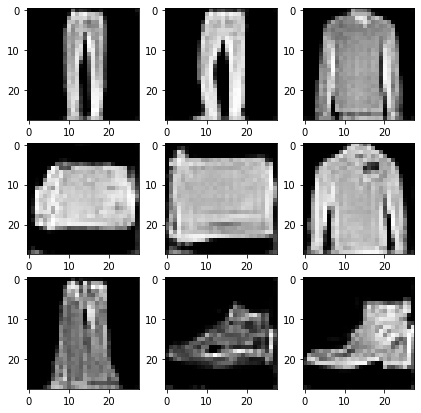

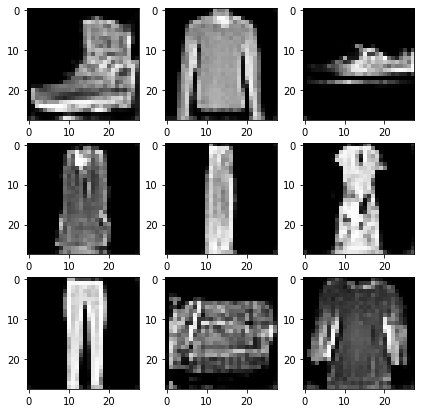

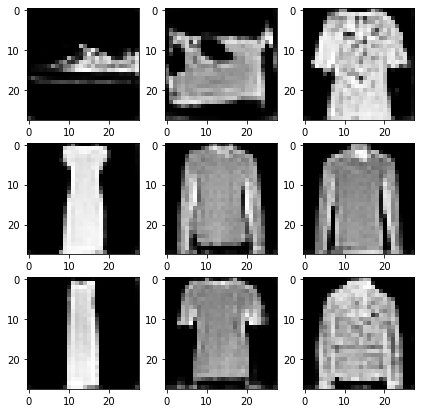

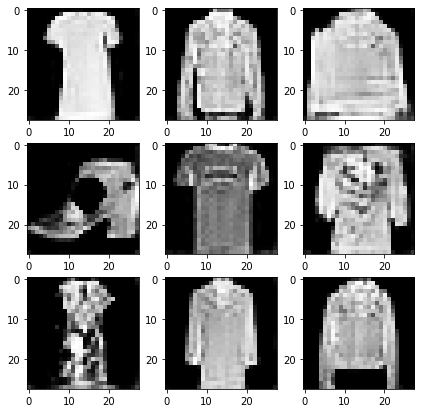

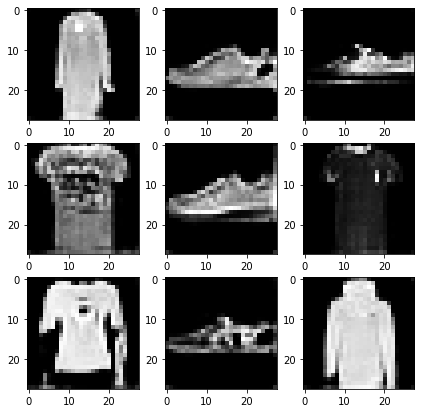

In [18]:
#Generating Unlimited samples
for i in range(5):
    show_generator_results(generator_network)